## Q3: Gaussian-Bernoulli Restricted Boltzmann Machines

In [8]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


In [9]:
batch_size = 128

transform = transforms.ToTensor()  # keeps pixels in [0,1]

train_dataset = torchvision.datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, drop_last=False
)

n_vis = 28 * 28
print("Visible dimension:", n_vis)


Visible dimension: 784


In [10]:
class GaussianBernoulliRBM(nn.Module):
    def __init__(self, n_vis, n_hid, k=1, sigma_val=1.0):
        super().__init__()
        self.n_vis = n_vis
        self.n_hid = n_hid
        self.k = k

        self.W = nn.Parameter(0.01 * torch.randn(n_vis, n_hid))
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hid))

        # fixed sigma_i
        sigma = torch.full((n_vis,), float(sigma_val))
        self.register_buffer("sigma", sigma)

    def hidden_prob(self, v):
        v_scaled = v / self.sigma
        return torch.sigmoid(v_scaled @ self.W + self.h_bias)

    def sample_h(self, v):
        p_h = self.hidden_prob(v)
        return torch.bernoulli(p_h), p_h

    def visible_mean(self, h):
        # mean of p(v|h)
        return self.v_bias + self.sigma * (h @ self.W.t())

    def sample_v(self, h):
        mean = self.visible_mean(h)
        # gaussian sample used only in CD:
        v_sample = mean + self.sigma * torch.randn_like(mean)
        return v_sample, mean

    def free_energy(self, v):
        v_centered = (v - self.v_bias) / self.sigma
        vis_term = 0.5 * (v_centered ** 2).sum(dim=1)
        hidden_lin = (v / self.sigma) @ self.W + self.h_bias
        hidden_term = F.softplus(hidden_lin).sum(dim=1)
        return vis_term - hidden_term

    def gibbs_k(self, v0):
        v = v0
        for _ in range(self.k):
            h, _ = self.sample_h(v)
            v, _ = self.sample_v(h)
        return v


In [11]:
def make_optimizer(rbm, lr=1e-3):
    return optim.Adam(rbm.parameters(), lr=lr)


def train_rbm(rbm, train_loader, epochs=25, lr=1e-3, verbose=True):
    rbm.train()
    opt = make_optimizer(rbm, lr=lr)

    for epoch in range(1, epochs + 1):
        total_loss = 0.0
        n_batches = 0

        for batch, _ in train_loader:
            batch = batch.view(batch.size(0), -1).to(device)

            v0 = batch
            # CD-1 negative sample
            vk = rbm.gibbs_k(v0).detach()

            # Free energy difference loss:
            loss = (rbm.free_energy(v0) - rbm.free_energy(vk)).mean()

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()
            n_batches += 1

        if verbose:
            print(f"Epoch {epoch:3d} | Loss: {total_loss / n_batches:.6f}")


@torch.no_grad()
def reconstruction_mse(rbm, data_loader):
    rbm.eval()
    total_se = 0.0
    total_pix = 0

    for batch, _ in data_loader:
        v0 = batch.view(batch.size(0), -1).to(device)
        # one-step reconstruction:
        h_prob = rbm.hidden_prob(v0)
        h_sample = torch.bernoulli(h_prob)
        v_mean = rbm.visible_mean(h_sample)

        # clip to [0,1] since inputs are in [0,1]
        v_mean = torch.clamp(v_mean, 0.0, 1.0)

        se = F.mse_loss(v_mean, v0, reduction="sum").item()
        total_se += se
        total_pix += v0.numel()

    return total_se / total_pix



In [13]:
hidden_sizes = [10, 50, 100, 250]
results = {}

for M in hidden_sizes:
    print(f"\n=== Training Gaussian-Bernoulli RBM with {M} hidden units ===")
    rbm = GaussianBernoulliRBM(n_vis=n_vis, n_hid=M, k=1).to(device)
    train_rbm(rbm, train_loader, epochs=25, lr=1e-3, verbose=True)

    test_mse = reconstruction_mse(rbm, test_loader)
    results[M] = (rbm, test_mse)
    print(f"Test reconstruction MSE (M={M}): {test_mse:.6f}")



=== Training Gaussian-Bernoulli RBM with 10 hidden units ===
Epoch   1 | Loss: -356.074600
Epoch   2 | Loss: -357.745492
Epoch   3 | Loss: -357.957886
Epoch   4 | Loss: -358.860389
Epoch   5 | Loss: -363.493862
Epoch   6 | Loss: -366.127349
Epoch   7 | Loss: -368.254419
Epoch   8 | Loss: -369.593607
Epoch   9 | Loss: -370.454461
Epoch  10 | Loss: -371.040498
Epoch  11 | Loss: -371.680281
Epoch  12 | Loss: -372.164262
Epoch  13 | Loss: -372.635438
Epoch  14 | Loss: -373.036469
Epoch  15 | Loss: -373.548179
Epoch  16 | Loss: -374.044232
Epoch  17 | Loss: -374.464832
Epoch  18 | Loss: -374.769481
Epoch  19 | Loss: -374.864906
Epoch  20 | Loss: -375.050380
Epoch  21 | Loss: -375.182436
Epoch  22 | Loss: -375.378754
Epoch  23 | Loss: -375.499984
Epoch  24 | Loss: -375.549753
Epoch  25 | Loss: -375.674578
Test reconstruction MSE (M=10): 0.040334

=== Training Gaussian-Bernoulli RBM with 50 hidden units ===
Epoch   1 | Loss: -362.264392
Epoch   2 | Loss: -370.176814
Epoch   3 | Loss: -372.62

Best hidden size by test MSE: M = 250


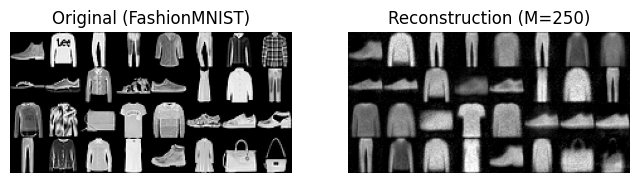

In [ ]:
best_M = min(results, key=lambda m: results[m][1])
rbm_best = results[best_M][0]
print(f"Best hidden size by test MSE: M = {best_M}")

rbm_best.eval()

# Take a small batch from the test set
data, _ = next(iter(test_loader))
data = data[:32]
v0 = data.view(data.size(0), -1).to(device)

with torch.no_grad():
    # h|v
    h_prob = rbm_best.hidden_prob(v0)
    h_sample = torch.bernoulli(h_prob)
    # mean of p(v|h)
    v_mean = rbm_best.visible_mean(h_sample)
    v_mean = torch.clamp(v_mean, 0.0, 1.0)

orig_grid = make_grid(data, padding=0)
recon_grid = make_grid(v_mean.view_as(data).cpu(), padding=0)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Original (FashionMNIST)")
plt.axis("off")
plt.imshow(orig_grid.permute(1, 2, 0).numpy(), cmap="gray")

plt.subplot(1, 2, 2)
plt.title(f"Reconstruction (M={best_M})")
plt.axis("off")
plt.imshow(recon_grid.permute(1, 2, 0).numpy(), cmap="gray")

plt.show()
